**Table of contents**<a id='toc0_'></a>    
- [**Angriffserkennung in Honeypot-Logs durch einen Autoencoder mit LSTM**](#toc1_)    
  - [Einleitung](#toc1_1_)    
  - [Datensatzbeschreibung](#toc1_2_)    
    - [Quellen](#toc1_2_1_)    
  - [Lizenz und Copyright](#toc1_3_)    
  - [Vorbereitung](#toc1_4_)    
    - [Importe](#toc1_4_1_)    
    - [TensorFlow-Version und GPU-Verfügbarkeit](#toc1_4_2_)    
  - [Datenladen & Basis-Cleaning](#toc1_5_)    
  - [Visualisierung des Datensatzes](#toc1_6_)    
    - [Angriffe vs normale Logs](#toc1_6_1_)    
    - [Fokus auf `http` Service](#toc1_6_2_)    
      - [Auswahl der HTTP-Daten](#toc1_6_2_1_)    
    - [Verteilung der Angriffstypen](#toc1_6_3_)    
  - [Datenauswahl für das Training](#toc1_7_)    
    - [Korrelation-Heatmap von HTTP-Features: Normalisierte Daten](#toc1_7_1_)    
  - [Auswahl der PCA-Coverage und Dimensionsreduktion](#toc1_8_)    
  - [Fensterbildung und zufällige Permutation von Daten](#toc1_9_)    
      - [Wichtige Parameter und ihre Bedeutung](#toc1_9_1_1_)    
      - [Alternative Ansätze zur Fensterbildung](#toc1_9_1_2_)    
      - [Sliding-Window-Ansatz](#toc1_9_1_3_)    
  - [Implementierung eines LSTM-Autoencoders mit Bayesian Optimization](#toc1_10_)    
      - [Notationen](#toc1_10_1_1_)    
      - [Rechenmodelle](#toc1_10_1_2_)    
      - [Optimierung mit Bayesian Optimization](#toc1_10_1_3_)    
      - [Ablauf](#toc1_10_1_4_)    
  - [Trainiere das finale Modell mit den besten Hyperparametern](#toc1_11_)    
    - [Testen des Autoencoders](#toc1_11_1_)    
  - [Verarbeitung und Vorbereitung der Testdaten](#toc1_12_)    
      - [Schritte zur Datenverarbeitung](#toc1_12_1_1_)    
      - [Anmerkung](#toc1_12_1_2_)    
  - [Bewertung des LSTM-Autoencoders und Anomalieerkennung](#toc1_13_)    
      - [Schritte zur Modellbewertung](#toc1_13_1_1_)    
  - [Verschiedene Metriken](#toc1_14_)    
  - [Kategoriale Kenngrößen](#toc1_15_)    
  - [Metriken für Klassifikationsmodelle](#toc1_16_)    
    - [Accuracy (Standard)](#toc1_16_1_)    
      - [Precision](#toc1_16_1_1_)    
      - [Recall](#toc1_16_1_2_)    
      - [F1-Score](#toc1_16_1_3_)    
      - [Tabelle: Übersicht der Begriffe](#toc1_16_1_4_)    
    - [ROC und AUC-Bewertung](#toc1_16_2_)    
      - [Visualisierung](#toc1_16_2_1_)    
      - [Wichtige Aspekte](#toc1_16_2_2_)    
    - [Precision-Recall-Kurve und Average Precision (AP)](#toc1_16_3_)    
    - [F1-Score-Kurve basierend auf Schwellenwerten](#toc1_16_4_)    
      - [Schritte zur Berechnung der F1-Score-Kurve](#toc1_16_4_1_)    
    - [Schwellenwertoptimierung und Bewertung der Anomalieerkennung](#toc1_16_5_)    
      - [Berechnung der Bewertungsmetriken](#toc1_16_5_1_)    
  - [Anomalieerkennung im Produktionsdatensatz](#toc1_17_)    
      - [Schritte zur Datenverarbeitung](#toc1_17_1_1_)    
      - [Anmerkung](#toc1_17_1_2_)    
    - [Ausgabe der gefundenen Anormalien](#toc1_17_2_)    
  - [Ausblick](#toc1_18_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[**Angriffserkennung in Honeypot-Logs durch einen Autoencoder mit LSTM**](#toc0_)


## <a id='toc1_1_'></a>[Einleitung](#toc0_)

Im Rahmen des Moduls „Künstliche Intelligenz und Maschinelles Lernen“ wird in diesem Projekt ein Ansatz zur Erkennung von Hackerangriffen mittels eines Autoencoders mit Long Short-Term Memory (LSTM) entwickelt und evaluiert. Ziel ist es, eine Grundlage für die Anwendung maschineller Lernmethoden zur Anomalieerkennung in Netzwerkdaten zu schaffen. Dabei liegt der Fokus auf der Analyse des HTTP-Protokolls als Einstieg in die Entwicklung eines umfassenderen Honeypots.

Ein Autoencoder ist ein neuronales Netzwerk, das darauf trainiert wird, Eingabedaten auf eine kompakte Repräsentation zu komprimieren und diese anschließend zu rekonstruieren. Anomalien werden erkannt, wenn die rekonstruierten Daten signifikant von den Originaldaten abweichen, da solche Abweichungen auf Muster hinweisen können, die das Modell nicht gelernt hat. Die Integration von LSTM-Schichten erlaubt es, zeitliche Abhängigkeiten in sequentiellen Daten, wie sie bei Netzwerkverkehr auftreten, effektiv zu modellieren.

Der in diesem Projekt verwendete KDD99-Datensatz ist ein Benchmark-Standard für Intrusion Detection Systeme und bietet eine Vielzahl von Netzwerkverbindungsdaten, die in normale Verbindungen und verschiedene Angriffstypen unterteilt sind. Im Rahmen dieses Projekts wird der Datensatz speziell für das HTTP-Protokoll untersucht. Das Modell wird trainiert, um Muster in normalen Verbindungen zu lernen und Abweichungen, die auf potenzielle Angriffe hinweisen, zu identifizieren.

Dieses Projekt bildet zugleich den Einstieg in die Vorbereitung einer Bachelorarbeit, die in Zusammenarbeit mit dem Bundesamt für Sicherheit in der Informationstechnik (BSI) durchgeführt wird. Während im aktuellen Projekt nur das HTTP-Protokoll analysiert wird, soll in der Bachelorarbeit ein erweiterter Ansatz entwickelt werden, der sich auf reale Honeypot-Daten des BSI stützt. Honeypots sind speziell gestaltete Systeme, die Cyberangreifer anziehen, um deren Angriffsmethoden zu analysieren und Daten über potenzielle Bedrohungen zu sammeln. Die Bachelorarbeit wird sich auf die Analyse mehrerer Protokolle fokussieren, um die Erkennung von Angriffen zu generalisieren und die Grundlagen für ein umfassenderes, protokollübergreifendes Intrusion Detection System zu schaffen.

Dieses Projekt im Modul „Künstliche Intelligenz und Maschinelles Lernen“ dient somit als wertvolle Basis, um theoretische Konzepte aus der Vorlesung mit praktischen Anwendungsfällen zu verbinden.


---

## <a id='toc1_2_'></a>[Datensatzbeschreibung](#toc0_)

Für die Modellierung der Intrusion-Detection-Aufgabe wird der **KDD99-Datensatz** verwendet, der weithin als Benchmark für IDS gilt. Der KDD99-Datensatz wurde aus dem DARPA1998-Projekt extrahiert und enthält 41 Merkmale, die aus rohen TCP-Paketen abgeleitet wurden. Diese Merkmale sind in vier Kategorien unterteilt:

1. **Basic Features**: Grundlegende Merkmale wie die Anzahl der Bytes, Dauer der Verbindung etc.
2. **Content Features**: Merkmale, die den Inhalt der Verbindung betreffen, wie die Anzahl der Fehlversuche bei Anmeldungen.
3. **Host-based Statistical Features**: Statistische Merkmale, die sich auf den Host beziehen, wie die Anzahl der Prozesse pro Verbindung.
4. **Time-based Statistical Features**: Zeitbezogene statistische Merkmale, die Muster in den Verbindungen über die Zeit hinweg erfassen.

### <a id='toc1_2_1_'></a>[Quellen](#toc0_)

- **KDD99 Dataset**: [KDD Cup 1999](http://kdd.ics.uci.edu/databases/kddcup99/task.html)
- **Download-Links**:
    - Trainingsdaten: [kdd_train.csv](http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz)
    - Testdaten: [kdd_test.csv](http://kdd.ics.uci.edu/databases/kddcup99/corrected.gz)
    - Produktionsdaten: [kdd_prod.csv](http://kdd.ics.uci.edu/databases/kddcup99/kddcup.newtestdata_10_percent_unlabeled.gz)
    - Spaltennamen: [kddcup.names](http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names)
- <https://lilianweng.github.io/posts/2018-08-12-vae/>\
- <https://victordibia.com/blog/introducing-anomagram/>
- https://www.jeremyjordan.me/autoencoders/
- Song, Y., Hyun, S., & Cheong, Y. G. (2021). Analysis of Autoencoders for Network Intrusion Detection. Sensors (Basel, Switzerland), 21(13), 4294. https://doi.org/10.3390/s21134294
- Vinayakumar, R., Alazab, M., Soman, K. P., Poornachandran, P., Al-Nemrat, A., & Venkatraman, S. (2019). Deep Learning Approach for Intelligent Intrusion Detection System. IEEE Access, 7, 41525-41550. https://ieeexplore.ieee.org/abstract/document/8681044
- Jason Brownlee https://machinelearningmastery.com/lstm-autoencoders/ und weitere
- Teile dieses Codes wurden mit ChatGPT-o1 generiert.



Der Datensatz umfasst sowohl gelabelte als auch ungelabelte Daten, wobei das Ziel darin besteht, ein Modell zu trainieren, das auf Live-Produktionsdaten angewendet werden kann, wo Labels nicht verfügbar sind.

---

## <a id='toc1_3_'></a>[Lizenz und Copyright](#toc0_)

MIT License

Copyright (c) 2024 Lukas Johannes Möller (github@pontis-it.com)

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [38]:
dummifiziere_categoricals = False # anstatt sie zu droppen

## <a id='toc1_4_'></a>[Vorbereitung](#toc0_)

### <a id='toc1_4_1_'></a>[Importe](#toc0_)

In [6]:
# Basis-Pakete
import os
import csv
import json
import random
import numpy as np
import pandas as pd
import tqdm
import statistics
import math
import scipy.stats as st


# Visualisierung
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
from IPython.display import Image
import pydot
import graphviz

# TensorFlow und Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.losses import BinaryCrossentropy

# Maschinelles Lernen
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
)
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score,
    confusion_matrix
)

# Bayesian Optimization
from bayes_opt import BayesianOptimization


### <a id='toc1_4_2_'></a>[TensorFlow-Version und GPU-Verfügbarkeit](#toc0_)

In [40]:
print('TensorFlow-Version:', tf.__version__)
print('Verfügbare GPU-Geräte:', tf.config.list_physical_devices('GPU'))

TensorFlow-Version: 2.10.1
Verfügbare GPU-Geräte: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## <a id='toc1_5_'></a>[Datenladen & Basis-Cleaning](#toc0_)

In diesem Abschnitt werden der Datensatz geladen und grundlegende Bereinigungen durchgeführt. Dazu zählt das Prüfen auf negative Werte in numerischen Spalten.


In [41]:
# Pfade zum Trainings- und Testdaten
TRAIN_DATEN_PFAD = 'kdd_train.csv'
SPALTENNAMEN_PFAD = 'columns_names.txt'
TEST_DATEN_PFAD = 'kdd_test.csv'
PROD_DATEN_PFAD = 'kdd_prod.csv'

# Einlesen der Spaltennamen
with open(SPALTENNAMEN_PFAD, 'r') as txt_file:
    spaltennamen_liste = txt_file.readlines()

bereinigte_spaltennamen = [
    col.split(':')[0] for col in spaltennamen_liste
    if len(col.split(':')) > 1
]

# Trainingsdaten einlesen
df_train = pd.read_csv(TRAIN_DATEN_PFAD, header=None)
print(f"Ursprungsform der Trainingsdaten: {df_train.shape}")

# Quick-Sanity-Check für die Spaltenanzahl
if len(bereinigte_spaltennamen) > len(df_train.columns):
    bereinigte_spaltennamen = bereinigte_spaltennamen[:len(df_train.columns)]
elif len(bereinigte_spaltennamen) < len(df_train.columns):
    bereinigte_spaltennamen.extend([f"Unnamed_{i}" for i in range(len(bereinigte_spaltennamen), len(df_train.columns))])

df_train.columns = bereinigte_spaltennamen

# Prüfung auf negative Werte in numerischen Spalten
numerische_spalten = df_train.select_dtypes(include=[np.number]).columns
for col in numerische_spalten:
    anzahl_negative = df_train[df_train[col] < 0].shape[0]
    if anzahl_negative > 0:
        print(f"Warnung: {anzahl_negative} negative Werte in {col}.")

df_train.head()

Ursprungsform der Trainingsdaten: (4898431, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,result
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


## <a id='toc1_6_'></a>[Visualisierung des Datensatzes](#toc0_)

### <a id='toc1_6_2_'></a>[Fokus auf `http` Service](#toc0_)

Aus der Analyse der verschieden Dienste stellt sich der HTTP Dienst als gut geeignet heraus diesen genauer zu untersuchen. Das zukünftige Model für das BSI sollte Service übergreifend funktionieren, in diesem Ansatz wird darauf zur Vereinfachung verzichtet.

      service    total  normal  anomaly  pct_anomaly
9       ecr_i  2811660    3456  2808204    99.877083
12    private  1100831   73853  1026978    93.291159
0        http   623091  619046     4045     0.649183
1        smtp    96554   95371     1183     1.225221
10      other    72653   56520    16133    22.205552
..        ...      ...     ...      ...          ...
66     tftp_u        3       3        0     0.000000
64    harvest        2       0        2   100.000000
65        aol        2       0        2   100.000000
67  http_8001        2       0        2   100.000000
63  http_2784        1       0        1   100.000000

[70 rows x 5 columns]


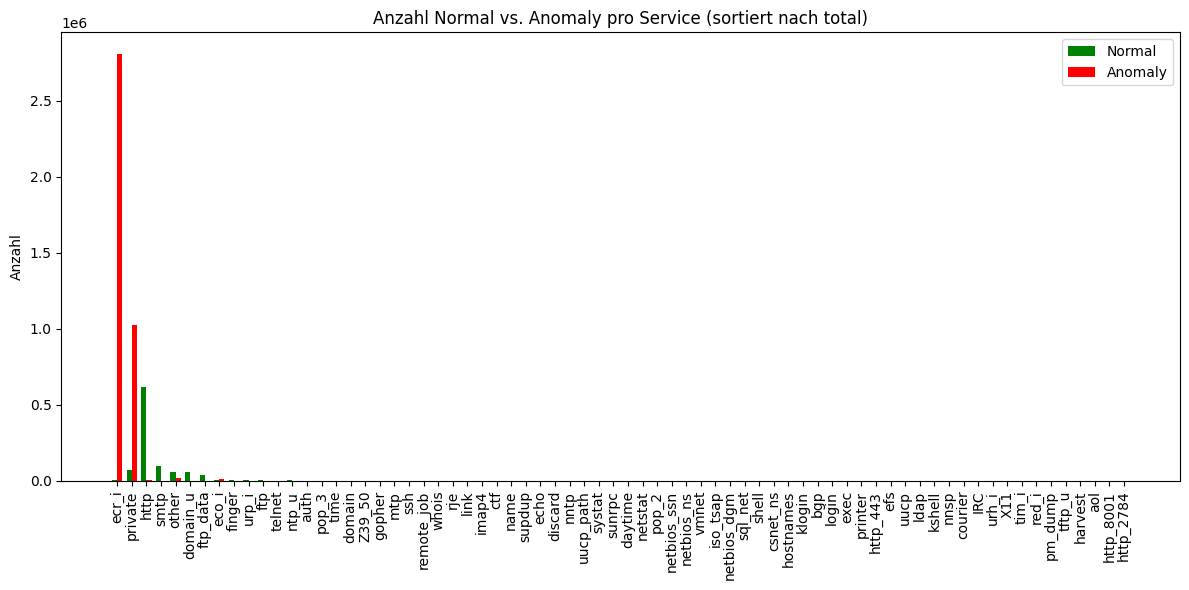

C:\Users\lukas\AppData\Local\Temp\ipykernel_13640\141643326.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_services['service'], rotation=90)


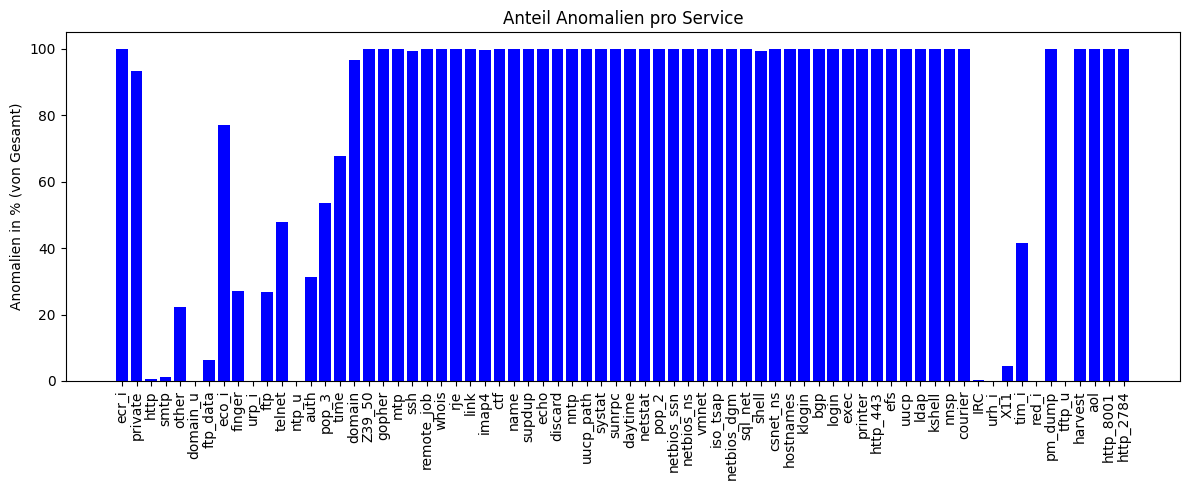

In [42]:
# 1) Aggregation pro Service
services = df_train['service'].unique()
service_aggregation = []

for svc in services:
    df_svc = df_train[df_train['service'] == svc]
    total_count   = len(df_svc)
    normal_count  = (df_svc['result'] == 'normal.').sum()
    anomaly_count = total_count - normal_count
    
    # Anteil (%) an Anomalien (0.0, falls total_count = 0)
    pct_anomaly = (anomaly_count / total_count * 100) if total_count > 0 else 0.0
    
    service_aggregation.append({
        'service': svc,
        'total': total_count,
        'normal': normal_count,
        'anomaly': anomaly_count,
        'pct_anomaly': pct_anomaly  # in Prozent
    })

df_services = pd.DataFrame(service_aggregation)

# 2) Nach absteigender total-Anzahl sortieren
df_services.sort_values(by='total', ascending=False, inplace=True)

# 3) Kontrolle
print(df_services)

# ### Visualisierung ###
# 4) Balkendiagramm (Normal vs. Anomaly), sortiert nach total
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
x_positions = range(len(df_services))
ax.bar(x_positions, df_services['normal'], width=bar_width, label='Normal', color='green')
ax.bar(
    [pos + bar_width for pos in x_positions],
    df_services['anomaly'],
    width=bar_width,
    label='Anomaly',
    color='red'
)
ax.set_xticks([pos + bar_width / 2 for pos in x_positions])
ax.set_xticklabels(df_services['service'], rotation=90)
ax.set_ylabel('Anzahl')
ax.set_title('Anzahl Normal vs. Anomaly pro Service (sortiert nach total)')
ax.legend()
plt.tight_layout()
plt.show()

# 5) Anteil Anomalien in %
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(df_services['service'], df_services['pct_anomaly'], color='blue')
ax.set_ylabel('Anomalien in % (von Gesamt)')
ax.set_title('Anteil Anomalien pro Service')
ax.set_xticklabels(df_services['service'], rotation=90)
plt.tight_layout()
plt.show()


#### <a id='toc1_6_2_1_'></a>[Auswahl der HTTP-Daten](#toc0_)

In [43]:
df_train_http = df_train[df_train['service'] == 'http']
df_train_http.shape

(623091, 42)

### <a id='toc1_6_3_'></a>[Verteilung der Angriffstypen](#toc0_)

C:\Users\lukas\AppData\Local\Temp\ipykernel_13640\1921923286.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df_train_http['result']).plot(kind='bar', figsize=(12, 4))


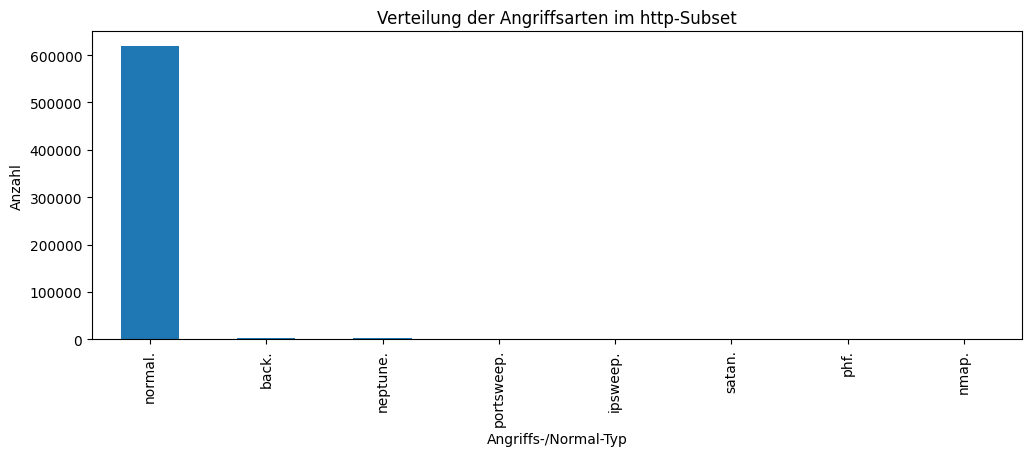

Prozentualer Anteil an Anomalien (im HTTP-Subset) = 0.65%


In [44]:
pd.value_counts(df_train_http['result']).plot(kind='bar', figsize=(12, 4))
plt.ylabel('Anzahl')
plt.xlabel('Angriffs-/Normal-Typ')
plt.title('Verteilung der Angriffsarten im http-Subset')
plt.show()

anzahl_normal = df_train_http[df_train_http['result'] == 'normal.'].shape[0]
anzahl_anomal = df_train_http[df_train_http['result'] != 'normal.'].shape[0]
print(f'Prozentualer Anteil an Anomalien (im HTTP-Subset) = {100*anzahl_anomal/anzahl_normal:.2f}%')

## <a id='toc1_7_'></a>[Datenauswahl für das Training](#toc0_)
Wir wählen hier nur die normalen HTTP-Daten aus, um einen One-Class-Ansatz zu fahren.

In [45]:
# Nur normale HTTP-Daten
df_train_http_normal = df_train_http[df_train_http['result'] == 'normal.'].copy()
print("Form der ursprünglichen Daten:", df_train_http_normal.shape)

# One-Hot-Encoding für kategoriale Spalten (abhängig von `dummifiziere_categoricals` parameter am Anfang)
kategoriale_spalten = df_train_http_normal.select_dtypes(include=['object', 'category']).columns
if dummifiziere_categoricals:
    print(f"Kategoriale Spalten für One-Hot-Encoding: {list(kategoriale_spalten)}")
    df_train_http_normal = pd.get_dummies(df_train_http_normal, columns=kategoriale_spalten, drop_first=False, dtype=int)
    print(f"Form der Daten nach One-Hot-Encoding: {df_train_http_normal.shape}")
else:
    df_train_http_normal = df_train_http_normal.drop(columns=kategoriale_spalten)

# Spalten ohne Standardabweichung entfernen
spalten_std = df_train_http_normal.std()
spalten_ohne_std = spalten_std[spalten_std == 0].index
df_train_http_normal = df_train_http_normal.drop(columns=spalten_ohne_std)
# aufgrund hoher Korrelationen wird die Spalte 'logged_in' entfernt (leider nur manuell)
df_train_http_normal =df_train_http_normal.drop(columns=['logged_in'])
# Beschreibung der finalen Daten
df_train_http_normal.describe()


Form der ursprünglichen Daten: (619046, 42)


,duration,src_bytes,dst_bytes,hot,num_compromised,root_shell,num_root,num_shells,num_access_files,count,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,619046.000000,619046.000000,6.190460e+05,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000,...,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000
mean,0.561887,238.164408,4.099786e+03,0.003489,0.000244,0.000312,0.000013,0.000010,0.005412,8.967949,...,127.590137,244.759520,0.997517,0.000701,0.074793,0.031858,0.001152,0.000697,0.087653,0.086727
std,13.927250,126.545153,2.371340e+04,0.081921,0.037207,0.017654,0.003595,0.003113,0.073364,9.252731,...,105.902328,39.788676,0.020105,0.006409,0.185882,0.050566,0.013363,0.003392,0.274847,0.268584
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,210.000000,4.580000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,21.000000,255.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,240.000000,1.425000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,...,96.000000,255.000000,1.000000,0.000000,0.010000,0.020000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,302.000000,3.727000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,...,255.000000,255.000000,1.000000,0.000000,0.050000,0.040000,0.000000,0.000000,0.000000,0.000000
max,3289.000000,54540.000000,1.173059e+07,21.000000,21.000000,1.000000,1.000000,1.000000,1.000000,511.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000,1.000000


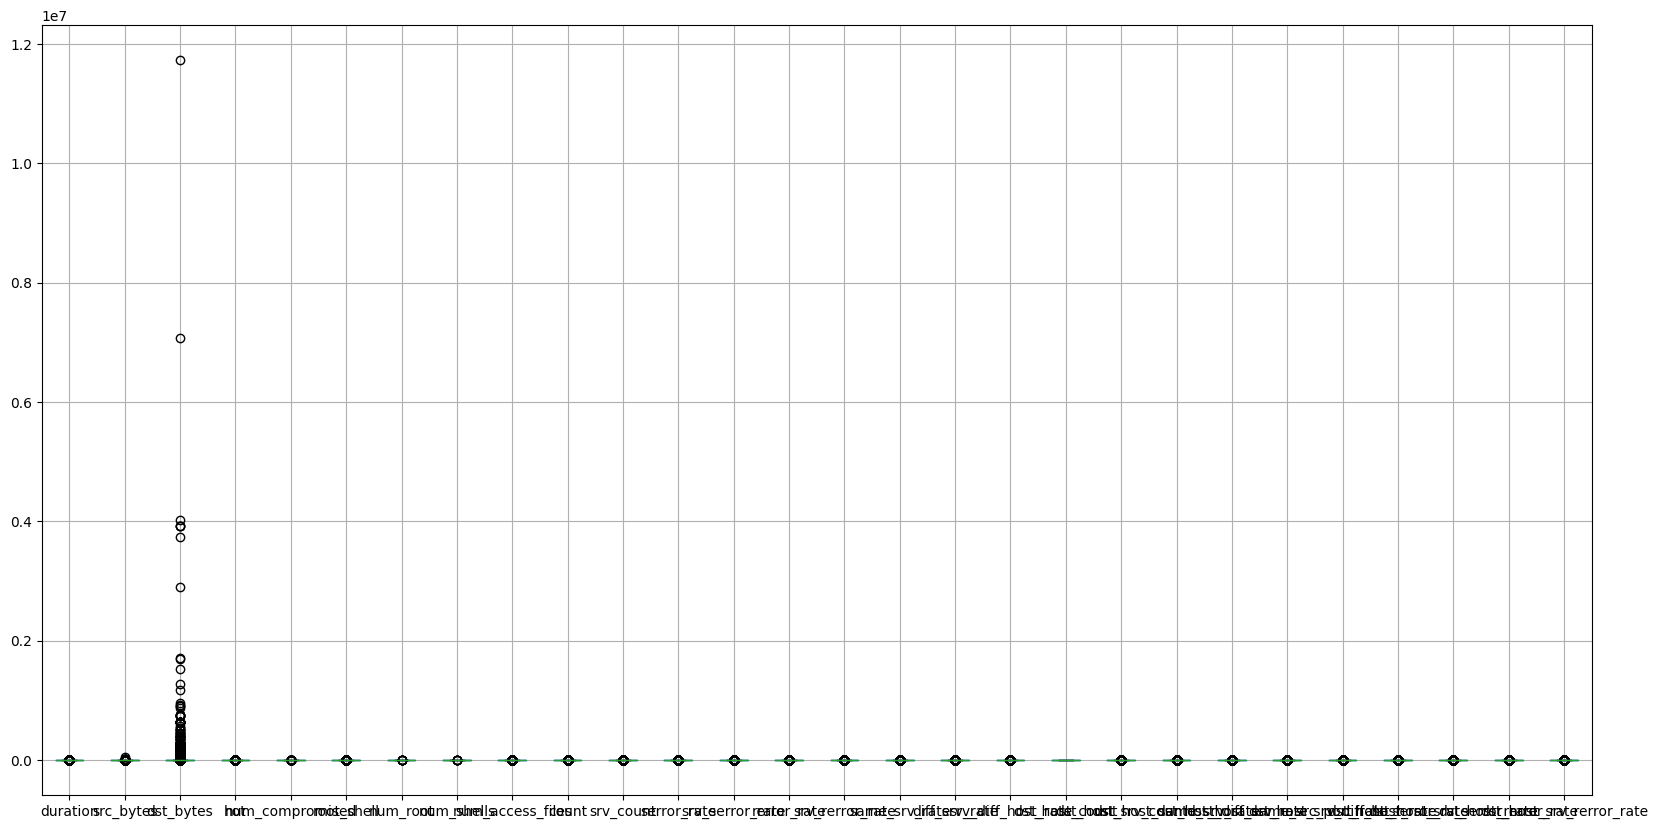

In [46]:
df_train_http_normal.boxplot(figsize=(20, 10))
plt.show()

### <a id='toc1_7_1_'></a>[Korrelation-Heatmap von HTTP-Features: Normalisierte Daten](#toc0_)
Hier betrachten wir nur die normalen HTTP-Daten (nach Normalisierung) und visualisieren eine Korrelation-Heatmap.

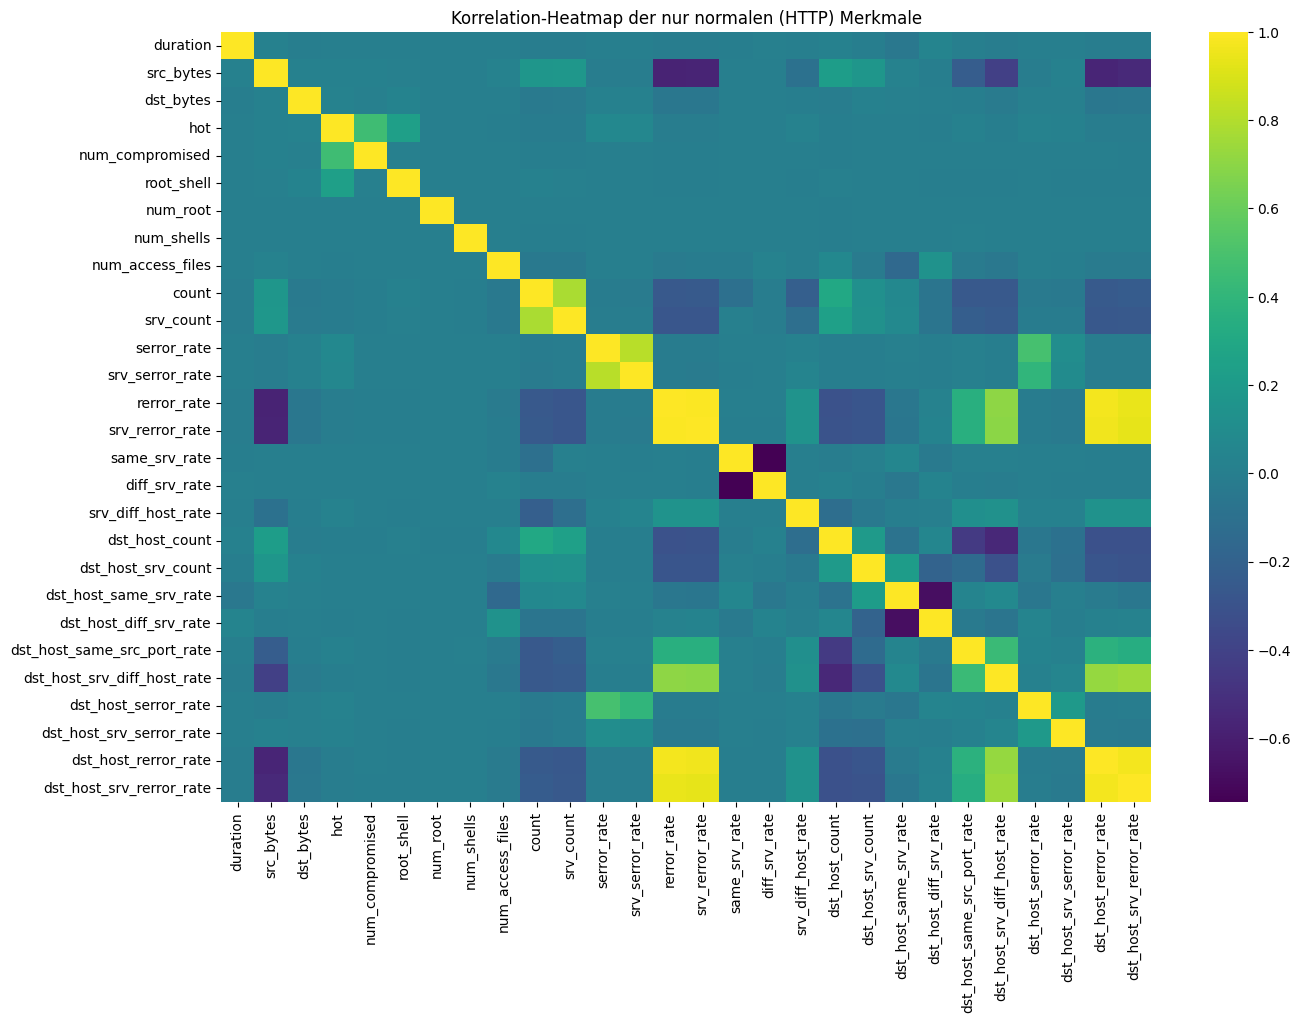

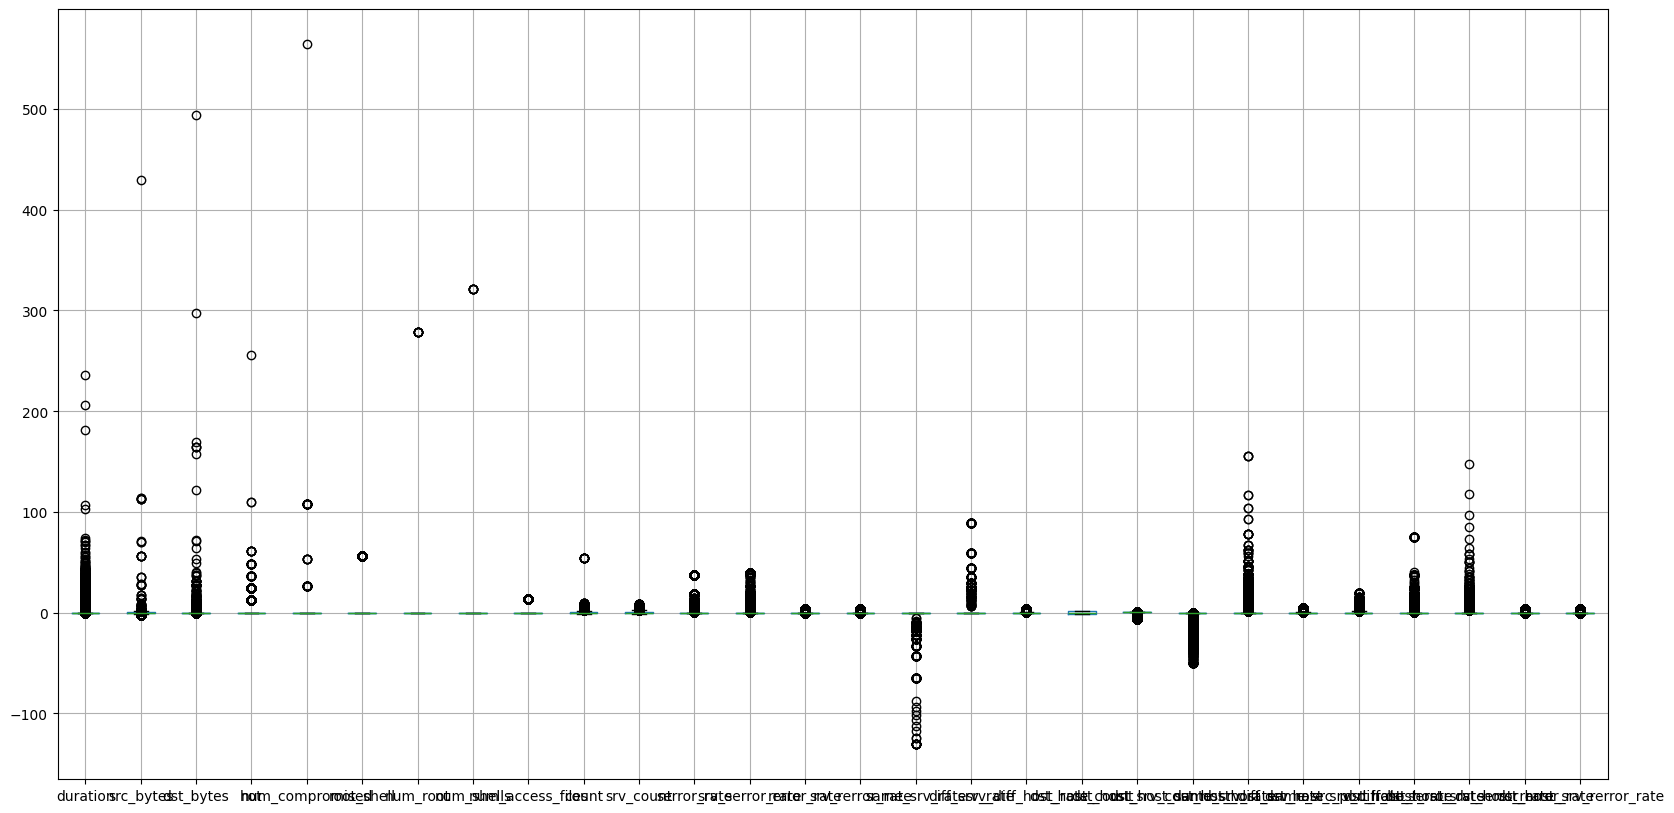

In [47]:
skalierer = StandardScaler()
df_train_http_normal = pd.DataFrame(
    skalierer.fit_transform(df_train_http_normal),
    columns=df_train_http_normal.columns
)

plt.figure(figsize=(15, 10))
sns.heatmap(df_train_http_normal.corr(), cmap='viridis')
plt.title('Korrelation-Heatmap der nur normalen (HTTP) Merkmale')
plt.show()
df_train_http_normal.boxplot(figsize=(20, 10))
plt.show()

## <a id='toc1_8_'></a>[Auswahl der PCA-Coverage und Dimensionsreduktion](#toc0_)
Principal Component Analysis (Hauptkomponentenanalyse) ermöglicht es hochdimensionale Datensätze auf weniger Dimensionen zu reduzieren.

Siehe: [scikit-Learn Dokumentation](https://scikit-learn.org/1.6/modules/generated/sklearn.decomposition.PCA.html)

MSE Mean Square Error

In [48]:
def crossval_pca_coverage(data: pd.DataFrame, coverages=[0.8,0.9,0.95], k=3):
    best_cov = coverages[0]
    best_mse = float('inf')
    data_np = data.to_numpy()
    kf = KFold(n_splits=k, shuffle=False)

    for cov in coverages:
        fold_mses = []
        for train_idx, val_idx in kf.split(data_np):
            X_tr = data_np[train_idx]
            X_val= data_np[val_idx]
            pca_temp = PCA(n_components=cov)
            pca_temp.fit(X_tr)
            X_val_pca = pca_temp.transform(X_val)
            X_val_rec = pca_temp.inverse_transform(X_val_pca)
            mse = np.mean((X_val - X_val_rec)**2)
            fold_mses.append(mse)
        avg_mse = np.mean(fold_mses)
        print(f"Coverage={cov} => avg MSE={avg_mse:.4f}")
        if avg_mse < best_mse:
            best_mse = avg_mse
            best_cov = cov

    return best_cov

coverages = [0.8, 0.9, 0.95, 1]
best_cov = crossval_pca_coverage(df_train_http_normal, coverages=coverages, k=3)
print("Beste Coverage:", best_cov)

# Endgültige PCA antrainieren
pca_modell = PCA(n_components=best_cov)
pca_modell.fit(df_train_http_normal)
pca_dim = pca_modell.n_components_
df_train_pca = pd.DataFrame(
    pca_modell.transform(df_train_http_normal),
    columns=[f'PCA_{i}' for i in range(pca_dim)]
)
print(f"PCA-Komponenten: {pca_dim}")
df_train_pca.head()

Coverage=0.8 => avg MSE=0.3423
Coverage=0.9 => avg MSE=0.2018
Coverage=0.95 => avg MSE=0.1548
Coverage=1 => avg MSE=0.8141
Beste Coverage: 0.95
PCA-Komponenten: 20


,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19
0,1.798859,3.088944,-29.703657,10.272687,9.938632,1.727932,5.309854,1.859650,0.355877,0.100662,0.108021,2.466347,-8.499384,-3.726095,-0.825376,3.480666,-2.275640,0.181676,-1.829727,-0.053964
1,1.967497,0.568716,-0.771258,1.566955,-1.499832,-0.431848,3.836505,0.189430,0.065545,-0.021060,-0.083078,0.425626,-0.499786,-0.914779,-2.183542,-3.405661,0.379561,-2.364467,4.149613,-0.313431
2,1.269001,0.462764,-1.034286,1.482814,-1.074706,-0.349238,3.144712,0.071235,-0.013609,-0.013818,-0.187998,0.231023,-0.123385,-1.041323,-0.984829,-4.226367,0.817237,-1.628993,2.341841,-0.169278
3,1.038257,0.400356,-1.093054,1.340184,-0.809126,-0.291742,2.937857,0.099897,-0.038134,-0.010789,-0.217200,0.226344,-0.021436,-1.016548,-0.579700,-4.441825,0.953444,-1.577512,1.699777,-0.121292
4,0.894030,0.357148,-1.109916,1.233189,-0.640405,-0.258253,2.864317,0.056544,-0.048781,-0.009322,-0.229586,0.170876,0.016926,-1.008761,-0.416988,-4.539245,1.013713,-1.501320,1.401663,-0.096516


## <a id='toc1_9_'></a>[Fensterbildung und zufällige Permutation von Daten](#toc0_)
Hier werden die Daten in überlappende Fenster aufgeteilt und anschließend zufällig permutiert.


#### <a id='toc1_9_1_1_'></a>[Wichtige Parameter und ihre Bedeutung](#toc0_)
- **Fenstergröße** (`window_size`)
- **Schrittweite** (`stride`)


#### <a id='toc1_9_1_2_'></a>[Alternative Ansätze zur Fensterbildung](#toc0_)
- Fixed Window, Expanding Window, Tumbling Window etc.


#### <a id='toc1_9_1_3_'></a>[Sliding-Window-Ansatz](#toc0_)

In diesem Abschnitt wird eine Funktion zur Fensterbildung implementiert.  
Die **Fenstergröße** (`fenster_groesse`) legt fest, wie viele aufeinanderfolgende Datenpunkte in einem Fenster enthalten sind. Sie ermöglicht es, zeitliche Muster über einen bestimmten Zeitraum zu erfassen. Eine zu kleine Fenstergröße könnte wichtige Muster verlieren, während eine zu große Fenstergröße Rechenressourcen verschwendet. 

Die **Schrittweite** (`schritt`) gibt an, wie weit das Fenster in den Daten voranschreitet. Eine kleinere Schrittweite erzeugt mehr überlappende Fenster, was die Modellrobustheit verbessern kann, jedoch die Berechnungszeit erhöht ([Volpe et al., 2024](https://doi.org/10.3390/s24247924)).

In diesem Beispiel verwenden wir:  
- `fenster_groesse=10`: Zur Erfassung kurzfristiger Muster.  
- `schritt=10`: Ohne Überlappung gab es die besten Ergbnisse

Der Sliding-Window-Ansatz ist hier sinnvoll, weil zeitliche Abhängigkeiten erfasst werden.


In [49]:
def fenster_bilden(df_eingabe, fenster_groesse, schritt):
    fenster_liste = []
    for i in tqdm.tqdm(range(0, len(df_eingabe) - fenster_groesse + 1, schritt)):
        fenster_liste.append(df_eingabe.iloc[i:i + fenster_groesse, :].to_numpy())
    return np.array(fenster_liste)
fenster_groesse=10
schrittweite=10

train_fenster = fenster_bilden(df_train_pca, fenster_groesse=fenster_groesse, schritt=schrittweite)
print('Form der Fenster:', train_fenster.shape)

# Shuffle
zufalls_indices = np.arange(train_fenster.shape[0])
np.random.shuffle(zufalls_indices)
train_fenster_shuffle = train_fenster[zufalls_indices]
train_fenster_shuffle.shape

100%|██████████| 61904/61904 [00:05<00:00, 12337.63it/s]


Form der Fenster: (61904, 10, 20)


(61904, 10, 20)

## <a id='toc1_10_'></a>[Implementierung eines LSTM-Autoencoders mit Bayesian Optimization](#toc0_)
Im Folgenden wird ein LSTM-Autoencoder definiert. Mithilfe einer Bayesian Optimization werden passende Hyperparameter gesucht.

#### <a id='toc1_10_1_1_'></a>[Notationen](#toc0_)
| Symbol | Beschreibung |
| - | - |
| $x$ | Eingabesequenz |
| $z$ | Latente Repräsentation (Encoder-Ausgabe) |
| $x'$ | Rekonstruktion (Decoder-Ausgabe) |
| $g_{\phi}(x)$ | Encoder-Funktion (Parameter $\phi$) |
| $f_{\theta}(z)$ | Decoder-Funktion (Parameter $\theta$) |
| $\mathcal{L}$ | Verlustfunktion (Rekonstruktionsfehler) |


#### <a id='toc1_10_1_2_'></a>[Rechenmodelle](#toc0_)
1. Encoding: $z = g_{\phi}(x)$
2. Decoding: $x' = f_{\theta}(z)$
3. Verlust: z. B. Huber Loss, MSE oder MAE.


#### <a id='toc1_10_1_3_'></a>[Optimierung mit Bayesian Optimization](#toc0_)
- Hyperparameter-Bereich (Anzahl Neuronen in LSTM-Schichten)
- Ziel: Minimierung des Validierungsverlusts.

![GpParBayesAnimationSmall.gif](GpParBayesAnimationSmall.gif)

By AnotherSamWilson - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=84842869

#### <a id='toc1_10_1_4_'></a>[Ablauf](#toc0_)
1. Baue LSTM-Autoencoder.
2. Trainiere mit gegebenen Parametern.
3. Bestimme Validierungsverlust.
4. Bayesian Optimization iteriert über Parameter.

sigmoid activation (Logistische Funktion)
$
\sigma(x) = \frac{1}{1 + e^{-x}}
$ Output Werte zwischen 0 und 1 

tanh (Tangens-Hyperbolicus-Funktion) activation
$
\text{tanh}(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$ Output Werte zwischen -1 und 1

``recurrent_activation`` bezieht sich auf die internen Zustände und die Speichermechansimen des Neurons

Die Wahl der Iterationen bei der Bayesian Search war nicht trivial. Ein Paper konnte allerdings eine grobe Richtung aufzeigen. [(Yperman et. al. 2016)](https://www.semanticscholar.org/paper/Bayesian-optimization-of-hyper-parameters-in-Yperman-Becker/1d198d646129133a82b876529f066f83878e2f59?utm_source=direct_link) Bei 6 Hyperparametern nahm der Normalisierter Mittlerer Quadratischer Fehler nach 50 Iterationen kaum noch ab.

Warum sigmoid schlechter als linear?

Für das Model wurde der functional API Ansatz von Keras gewählt. https://keras.io/guides/functional_api/

In [ ]:

# Funktion zur Aktualisierung und Speicherung der besten Ergebnisse
def aktualisiere_beste_ergebnisse(aktuelle_ergebnisse):
    global beste_ergebnisse_erst
    if (
        beste_ergebnisse_erst is None or
        aktuelle_ergebnisse['score'] > beste_ergebnisse_erst['score']
    ):
        beste_ergebnisse_erst = aktuelle_ergebnisse
        with open(beste_ergebnisse_datei, "w") as f:
            json.dump(beste_ergebnisse_erst, f, indent=2)
        print("Beste Ergebnisse aktualisiert:", beste_ergebnisse_erst)

# Datei zur Speicherung der besten Ergebnisse
beste_ergebnisse_datei = "beste_ergebnisse.json"

# Beste Ergebnisse laden, falls die Datei existiert
if os.path.exists(beste_ergebnisse_datei):
    with open(beste_ergebnisse_datei, "r") as f:
        beste_ergebnisse_erst = json.load(f)
else:
    beste_ergebnisse_erst = None

def baue_autoencoder(
    anzahl_neuronen_1, 
    anzahl_neuronen_2, 
    anzahl_neuronen_3, 
    fenster_groesse, 
    anzahl_merkmale,
    learning_rate,
    verlustfunktion='huber'
):
    """
    Baut ein Autoencoder-Modell basierend auf dem in der Frage
    gezeigten Encoder-Decoder-Aufbau mit gestapelten LSTM-Schichten.
    """
    
    # Input-Layer
    input_layer = Input(shape=(fenster_groesse, anzahl_merkmale), name="input_layer")
    
    # ------------------- Encoder ------------------- 
    # 1. LSTM-Schicht (mit return_sequences=True)
    x = LSTM(
        units=int(anzahl_neuronen_1),
        return_sequences=True,
        activation='tanh',
        recurrent_activation='sigmoid',
        dropout=0.0,
        recurrent_dropout=0.0
    )(input_layer)
    
    # 2. LSTM-Schicht (mit return_sequences=True)
    x = LSTM(
        units=int(anzahl_neuronen_2),
        return_sequences=True,
        activation='tanh',
        recurrent_activation='sigmoid',
        dropout=0.0,
        recurrent_dropout=0.0
    )(x)
    
    # 3. LSTM-Schicht (latent space, ohne return_sequences)
    latent_space = LSTM(
        units=int(anzahl_neuronen_3),
        activation='tanh',
        recurrent_activation='sigmoid',
        dropout=0.0,
        recurrent_dropout=0.0,
        name='latent_space'
    )(x)
    
    # ------------------- Decoder -------------------
    # Wiederholen des latent-space Vektors für jedes Zeitschritt-Fenster
    x = RepeatVector(fenster_groesse)(latent_space)
    
    # 1. Decoder-LSTM-Schicht
    x = LSTM(
        units=int(anzahl_neuronen_2),
        return_sequences=True,
        activation='tanh',
        recurrent_activation='sigmoid',
        dropout=0.0,
        recurrent_dropout=0.0
    )(x)
    
    # 2. Decoder-LSTM-Schicht
    x = LSTM(
        units=int(anzahl_neuronen_1),
        return_sequences=True,
        activation='tanh',
        recurrent_activation='sigmoid',
        dropout=0.0,
        recurrent_dropout=0.0
    )(x)
    
    # Ausgabe-Schicht mit TimeDistributed(Dense(...))
    output_layer = TimeDistributed(
        Dense(int(anzahl_merkmale), activation='linear')
    )(x)
    
    # Komplettes Autoencoder-Modell
    autoencoder_ges = Model(inputs=input_layer, outputs=output_layer, name="autoencoder")

    # Optimierer mit dynamischer Lernrate und Gradienten-Clipping
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipvalue=1.0)

    # Modell kompilieren
    autoencoder_ges.compile(optimizer=optimizer, loss=tf.keras.losses.Huber())
    return autoencoder_ges


# Zielfunktion für die Optimierung
def trainiere_und_bewerte(
    anzahl_neuronen_1, 
    anzahl_neuronen_2, 
    anzahl_neuronen_3,
    learning_rate,
    batch_size
):
    # Konvertiere Batch-Größe zu Integer
    batch_size = int(batch_size)
    
    # Leere die vorherige Keras-Sitzung
    K.clear_session()
    
    # Bau des Autoencoders mit den aktuellen Hyperparametern
    modell_aktuell = baue_autoencoder(
        anzahl_neuronen_1=int(anzahl_neuronen_1),
        anzahl_neuronen_2=int(anzahl_neuronen_2),
        anzahl_neuronen_3=int(anzahl_neuronen_3),
        fenster_groesse=fenster_groesse,
        anzahl_merkmale=pca_modell.n_components_,
        learning_rate=learning_rate,
        verlustfunktion='huber'
    )
    
    # Define ModelCheckpoint Callback
    temp_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'temp_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=0
    )
    
    # Training des Modells
    verlauf = modell_aktuell.fit(
        train_fenster_shuffle,                # Eingabedaten (x)
        train_fenster_shuffle,
        batch_size=batch_size,                # Dynamische Batch-Größe
        validation_split=0.2,
        epochs=10,
        callbacks=[temp_checkpoint],
        verbose=0
    )
    
    # Besten Validierungs-Loss ermitteln
    bester_valverlust = min(verlauf.history['val_loss'])
    
    # Optional: Modell nach dem Training löschen, um Speicher freizugeben
    del modell_aktuell
    tf.keras.backend.clear_session()
    
    # Negativen Validierungs-Loss zurückgeben (da Bayesian Optimization maximieren möchte)
    return -bester_valverlust

# Funktion zur Durchführung der Optimierung mit Zwischenspeicherung
def optimierung_mit_speicherung(bo_optimizer, init_points, n_iter):
    try:
        bo_optimizer.maximize(init_points=init_points, n_iter=n_iter)
    except KeyboardInterrupt:
        print("Optimierung unterbrochen.")
    finally:
        # Verarbeite alle bisherigen Ergebnisse
        for res in bo_optimizer.res:
            # Rundet die Hyperparameter zu den erforderlichen Typen
            aktuelle_hyperparameter = res['params']
            aktuelle_hyperparameter['batch_size'] = int(round(aktuelle_hyperparameter['batch_size']))
            aktuelle_hyperparameter['anzahl_neuronen_1'] = int(round(aktuelle_hyperparameter['anzahl_neuronen_1']))
            aktuelle_hyperparameter['anzahl_neuronen_2'] = int(round(aktuelle_hyperparameter['anzahl_neuronen_2']))
            aktuelle_hyperparameter['anzahl_neuronen_3'] = int(round(aktuelle_hyperparameter['anzahl_neuronen_3']))
            
            aktuelle_ergebnisse = {
                'hyperparameter': aktuelle_hyperparameter,
                'score': res['target']
            }
            
            # Aktualisiere die besten Ergebnisse
            aktualisiere_beste_ergebnisse(aktuelle_ergebnisse)
        
        if beste_ergebnisse_erst is not None:
            print("Beste Ergebnisse nach Abbruch:", beste_ergebnisse_erst)
        else:
            print("Keine Ergebnisse vorhanden.")

# Bayesian Optimization - erster Durchlauf mit erweiterter Hyperparameter-Räume
hyperparameter_raender = {
    'anzahl_neuronen_1': (64, 256),
    'anzahl_neuronen_2': (32, 128),
    'anzahl_neuronen_3': (16, 64),
    'learning_rate': (1e-4, 1e-2),  # Lernrate auf log-Skala
    'batch_size': (32, 128)          # Batch-Größe als diskreter Wert
}

# Initialisiere den Bayesian Optimizer
bo_optimizer = BayesianOptimization(
    f=trainiere_und_bewerte,
    pbounds=hyperparameter_raender,
    random_state=42,
    verbose=2
)

# Anzahl der initialen Punkte und Iterationen festlegen
init_points_zahl = 10
n_iter_zahl = 100

# Starte die Optimierung
optimierung_mit_speicherung(bo_optimizer, init_points_zahl, n_iter_zahl)


|   iter    |  target   | anzahl... | anzahl... | anzahl... | batch_... | learni... |
-------------------------------------------------------------------------------------
| 1         | -0.02528  | 135.9     | 123.3     | 51.14     | 89.47     | 0.001645  |
| 2         | -0.0299   | 93.95     | 37.58     | 57.58     | 89.71     | 0.00711   |
| 3         | -0.02525  | 67.95     | 125.1     | 55.96     | 52.38     | 0.0019    |
| 4         | -0.02976  | 99.21     | 61.21     | 41.19     | 73.47     | 0.002983  |
| 5         | -0.0337   | 181.5     | 45.39     | 30.02     | 67.17     | 0.004615  |
| 6         | -0.04017  | 214.8     | 51.17     | 40.68     | 88.87     | 0.0005599 |
| 7         | -0.03445  | 180.6     | 48.37     | 19.12     | 123.1     | 0.00966   |
| 8         | -0.03114  | 219.2     | 61.24     | 20.69     | 97.69     | 0.004458  |
| 9         | -0.03201  | 87.43     | 79.54     | 17.65     | 119.3     | 0.002662  |
| 10        | -0.02765  | 191.2     | 61.92     | 40.9

## <a id='toc1_11_'></a>[Trainiere das finale Modell mit den besten Hyperparametern](#toc0_)
Wir verwenden die im zweiten Durchlauf ermittelten Hyperparameter. Anschließend stellen wir sicher, dass wir das Modell etwas länger trainieren. Zusätzlich plotten wir den Training-/Validierungsloss.

Der Versuch das Modell auf erweiterter Hardware zu trainieren verlief leider erfolglos. Tensorflow hatte Probleme die Hardware parallel zu nutzen, der Scheduler scheint optimierungspotential zu haben.

![training.png](training.png)

In [12]:
# 2. Laden des Autoencoders
autoencoder = tf.keras.models.load_model('autoencoder.h5', compile=False)
autoencoder.summary()

# 3. Extrahieren des Encoders
# Ersetze 'latent_layer' durch den tatsächlichen Namen der latenten Schicht
latent_layer_name = 'latent_layer'  # Beispielname, anpassen!
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(latent_space).output)
encoder.summary()

# 4. Transformieren der Daten in den latenten Raum
data = df_train_http_normal.values
latent_representations = encoder.predict(data)
latent_dim = latent_representations.shape[1]
latent_columns = [f'Latent_{i+1}' for i in range(latent_dim)]
df_latent = pd.DataFrame(latent_representations, columns=latent_columns)

# Optional: Hinzufügen der Label-Spalte
if 'Label' in df_train_http_normal.columns:
    df_latent['Label'] = df_train_http_normal['Label'].values

# 5. Visualisierung des Latenten Raums
# a. Direkte Visualisierung (falls 2D latenter Raum)
if latent_dim == 2:
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x='Latent_1',
        y='Latent_2',
        data=df_latent,
        hue='Label' if 'Label' in df_latent.columns else None,
        palette='viridis',
        s=50,
        alpha=0.7,
        edgecolor='k',
        linewidth=0.5
    )
    plt.title('Visualisierung des 2D Latenten Raums', fontsize=16)
    plt.xlabel('Latent_1', fontsize=14)
    plt.ylabel('Latent_2', fontsize=14)
    plt.legend(title='Label') if 'Label' in df_latent.columns else None
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    # b. Reduktion mit UMAP (falls >2D latenter Raum)
    reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='euclidean', random_state=42)
    latent_embedding = reducer.fit_transform(df_latent.drop('Label', axis=1) if 'Label' in df_latent.columns else df_latent)
    df_latent_umap = pd.DataFrame(latent_embedding, columns=['UMAP1', 'UMAP2'])
    
    # Füge die Label-Spalte hinzu, falls vorhanden
    if 'Label' in df_latent.columns:
        df_latent_umap['Label'] = df_latent['Label']
    
    # Visualisierung des UMAP-reduzierten Latenten Raums
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x='UMAP1',
        y='UMAP2',
        data=df_latent_umap,
        hue='Label' if 'Label' in df_latent_umap.columns else None,
        palette='viridis',
        s=50,
        alpha=0.7,
        edgecolor='k',
        linewidth=0.5
    )
    plt.title('UMAP-Visualisierung des Latenten Raums', fontsize=16)
    plt.xlabel('UMAP1', fontsize=14)
    plt.ylabel('UMAP2', fontsize=14)
    plt.legend(title='Label') if 'Label' in df_latent_umap.columns else None
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Interaktive Visualisierung mit Plotly
    fig = px.scatter(
        df_latent_umap,
        x='UMAP1',
        y='UMAP2',
        color='Label' if 'Label' in df_latent_umap.columns else None,
        title='Interaktive UMAP-Visualisierung des Latenten Raums',
        opacity=0.7,
        hover_data=df_latent_umap.columns.tolist()
    )
    fig.show()

    # Vergleich mit PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df_latent.drop('Label', axis=1) if 'Label' in df_latent.columns else df_latent)
    df_latent_pca = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
    
    if 'Label' in df_latent.columns:
        df_latent_pca['Label'] = df_latent['Label']
    
    plt.figure(figsize=(24, 10))
    
    # PCA-Plot
    plt.subplot(1, 2, 1)
    sns.scatterplot(
        x='PCA1',
        y='PCA2',
        hue='Label' if 'Label' in df_latent_pca.columns else None,
        palette='viridis',
        data=df_latent_pca,
        s=50,
        alpha=0.7,
        edgecolor='k',
        linewidth=0.5
    )
    plt.title('PCA-Visualisierung des Latenten Raums', fontsize=16)
    plt.xlabel('PCA1', fontsize=14)
    plt.ylabel('PCA2', fontsize=14)
    plt.legend(title='Label') if 'Label' in df_latent_pca.columns else None
    plt.grid(True)
    
    # UMAP-Plot
    plt.subplot(1, 2, 2)
    sns.scatterplot(
        x='UMAP1',
        y='UMAP2',
        hue='Label' if 'Label' in df_latent_umap.columns else None,
        palette='viridis',
        data=df_latent_umap,
        s=50,
        alpha=0.7,
        edgecolor='k',
        linewidth=0.5
    )
    plt.title('UMAP-Visualisierung des Latenten Raums', fontsize=16)
    plt.xlabel('UMAP1', fontsize=14)
    plt.ylabel('UMAP2', fontsize=14)
    plt.legend(title='Label') if 'Label' in df_latent_umap.columns else None
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 10, 20)]          0         
                                                                 
 lstm (LSTM)                 (None, 10, 68)            24208     
                                                                 
 lstm_1 (LSTM)               (None, 10, 125)           97000     
                                                                 
 latent_space (LSTM)         (None, 56)                40768     
                                                                 
 repeat_vector (RepeatVector  (None, 10, 56)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 10, 125)           91000     
                                                       

NameError: name 'latent_space' is not defined

Validation-Loss des gespeicherten Modells: 0.01702985167503357
Verwende finale Hyperparameter: {'anzahl_neuronen_1': 135, 'anzahl_neuronen_2': 122, 'anzahl_neuronen_3': 55, 'batch_size': 86, 'learning_rate': 0.0019848492364047347}
Epoch 1/100
575/576 [============================>.] - ETA: 0s - loss: 0.0755
Epoch 1: val_loss improved from inf to 0.05689, saving model to autoencoder_temp.h5
576/576 [==============================] - 18s 20ms/step - loss: 0.0754 - val_loss: 0.0569
Epoch 2/100
575/576 [============================>.] - ETA: 0s - loss: 0.0525
Epoch 2: val_loss improved from 0.05689 to 0.04788, saving model to autoencoder_temp.h5
576/576 [==============================] - 12s 22ms/step - loss: 0.0525 - val_loss: 0.0479
Epoch 3/100
576/576 [==============================] - ETA: 0s - loss: 0.0468
Epoch 3: val_loss improved from 0.04788 to 0.04371, saving model to autoencoder_temp.h5
576/576 [==============================] - 12s 21ms/step - loss: 0.0468 - val_loss: 0.0437
Ep

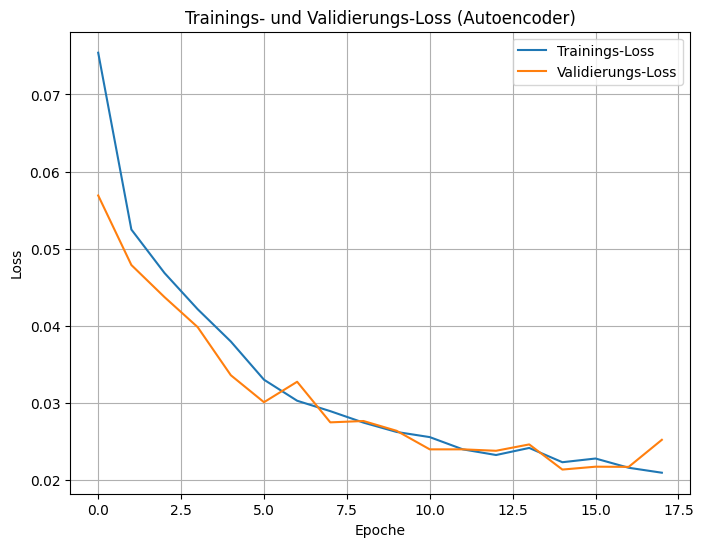

In [15]:
# Funktion, um den Validation-Loss des gespeicherten Modells zu berechnen
def berechne_val_loss_gespeichertes_modell(gespeichertes_modell, val_data):
    gespeichertes_modell.compile(optimizer='adam', loss='huber')
    val_loss = gespeichertes_modell.evaluate(val_data, val_data, verbose=0)
    return val_loss

# Datei mit den besten Ergebnissen
beste_ergebnisse_datei = "beste_ergebnisse.json"

# Beste Hyperparameter laden
if os.path.exists(beste_ergebnisse_datei):
    with open(beste_ergebnisse_datei, "r") as f:
        gespeicherte_ergebnisse = json.load(f)
        finale_parameter = gespeicherte_ergebnisse.get("hyperparameter", {})
else:
    raise FileNotFoundError("Die Datei mit den besten Ergebnissen wurde nicht gefunden!")

# Sicherstellen, dass die notwendigen Hyperparameter vorhanden sind
required_keys = [
    'anzahl_neuronen_1', 
    'anzahl_neuronen_2', 
    'anzahl_neuronen_3',
    'learning_rate',
    'batch_size'
]
if not all(key in finale_parameter for key in required_keys):
    raise ValueError(
        "Die gespeicherten Hyperparameter sind unvollständig! "
        "Erforderlich: anzahl_neuronen_1, anzahl_neuronen_2, "
        "anzahl_neuronen_3, learning_rate, batch_size"
    )

# Extrahiere Lernrate und Batch-Größe aus den finalen Parametern
learning_rate_final = finale_parameter['learning_rate']
batch_size_final = int(finale_parameter['batch_size'])  # Sicherstellen, dass es ein Integer ist

# Validation-Loss des gespeicherten Modells laden, falls vorhanden
if os.path.exists('autoencoder.h5'):
    try:
        gespeichertes_modell = tf.keras.models.load_model('autoencoder.h5', compile=False)
        gespeichertes_modell_val_loss = berechne_val_loss_gespeichertes_modell(
            gespeichertes_modell,
            val_data=train_fenster_shuffle[int(len(train_fenster_shuffle) * 0.8):]
        )
        print(f"Validation-Loss des gespeicherten Modells: {gespeichertes_modell_val_loss}")
    except Exception as e:
        print(f"Fehler beim Laden des gespeicherten Modells: {e}")
else:
    print("Kein gespeichertes Modell gefunden. Training eines neuen Modells.")

# Neues Modelltraining mit den finalen Hyperparametern
K.clear_session()

print("Verwende finale Hyperparameter:", finale_parameter)

finales_modell = baue_autoencoder(
    anzahl_neuronen_1=finale_parameter['anzahl_neuronen_1'],
    anzahl_neuronen_2=finale_parameter['anzahl_neuronen_2'],
    anzahl_neuronen_3=finale_parameter['anzahl_neuronen_3'],
    fenster_groesse=fenster_groesse,
    anzahl_merkmale=pca_modell.n_components_,
    learning_rate=learning_rate_final,  # Lernrate übergeben
    verlustfunktion='huber'
)

# Callbacks definieren
checkpoint_final = tf.keras.callbacks.ModelCheckpoint(
    'autoencoder_temp.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,              # Anzahl der Epochen ohne Verbesserung, bevor das Training gestoppt wird
    restore_best_weights=True,  # Die besten Gewichte werden nach dem Stoppen wiederhergestellt
    verbose=1
)

# Trainings-Verlauf starten mit der geladenen Batch-Größe
trainings_verlauf = finales_modell.fit(
    train_fenster_shuffle,                # Eingabedaten (x)
    train_fenster_shuffle,
    batch_size=batch_size_final,          # Geladene Batch-Größe verwenden
    validation_split=0.2,
    epochs=100,
    callbacks=[checkpoint_final, early_stop],  # EarlyStopping 
    verbose=1
)

# Validation-Loss des neu trainierten Modells berechnen
neu_val_loss = min(trainings_verlauf.history['val_loss'])
print(f"Validation-Loss des neu trainierten Modells: {neu_val_loss}")

if 'gespeichertes_modell_val_loss' in locals():
    if neu_val_loss < gespeichertes_modell_val_loss:
        print("Das neu trainierte Modell ist besser. Es wird als 'autoencoder.h5' gespeichert.")
        if os.path.exists('autoencoder.h5'):
            os.remove('autoencoder.h5')  # Existierende Datei entfernen
        os.replace('autoencoder_temp.h5', 'autoencoder.h5')  # Datei umbenennen und überschreiben
    else:
        print("Das neu trainierte Modell ist nicht besser. Das gespeicherte Modell bleibt erhalten.")
        if os.path.exists('autoencoder_temp.h5'):
            os.remove('autoencoder_temp.h5')  # Temporäre Datei entfernen
else:
    # Wenn kein gespeichertes Modell existierte oder das Laden fehlgeschlagen ist
    print("Kein gespeichertes Modell vorhanden oder Laden fehlgeschlagen. Das neu trainierte Modell wird gespeichert als 'autoencoder.h5'.")
    os.replace('autoencoder_temp.h5', 'autoencoder.h5')

# Plot: Trainings- und Validierungs-Loss
plt.figure(figsize=(8, 6))
plt.plot(trainings_verlauf.history['loss'], label='Trainings-Loss')
plt.plot(trainings_verlauf.history['val_loss'], label='Validierungs-Loss')
plt.title('Trainings- und Validierungs-Loss (Autoencoder)')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


### <a id='toc1_11_1_'></a>[Testen des Autoencoders](#toc0_)
Die Funktion cross_validate_autoencoder führt eine K-Fold-Cross-Validation durch, um die Leistung eines Autoencoder-Modells zu bewerten. Das Modell wird auf mehreren Daten-Splits trainiert, und die Validierungsverluste werden gesammelt, um die Stabilität und Generalisierungsfähigkeit zu analysieren.

In [17]:
# Funktion zur Cross-Validation mit geladenem Modell
def cross_validate_autoencoder(n_splits=3, epochs=5, batch_size=batch_size_final):
    """
    Führt eine K-Fold-Cross-Validation auf 'train_fenster_shuffle' durch.
    
    Args:
        n_splits (int): Anzahl der Folds für KFold.
        epochs (int): Anzahl Trainings-Epochen pro Fold.
        batch_size (int): Batchgröße beim Training.
        
    Returns:
        List[float]: Liste der Validierungs-Verluste pro Fold.
    """
    # Validierungs-Verluste initialisieren
    val_losses = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Beste Hyperparameter und gespeichertes Modell laden
    beste_ergebnisse_datei = "beste_ergebnisse.json"
    if os.path.exists(beste_ergebnisse_datei):
        with open(beste_ergebnisse_datei, "r") as f:
            gespeicherte_ergebnisse = json.load(f)
            finale_parameter = gespeicherte_ergebnisse.get("hyperparameter", {})
    else:
        raise FileNotFoundError("Die Datei mit den besten Ergebnissen wurde nicht gefunden!")

    # Sicherstellen, dass die Hyperparameter vollständig sind
    required_keys = ['anzahl_neuronen_1', 'anzahl_neuronen_2', 'anzahl_neuronen_3']
    if not all(key in finale_parameter for key in required_keys):
        raise ValueError("Die gespeicherten Hyperparameter sind unvollständig!")

    # Cross-Validation-Schleife
    for train_index, val_index in kf.split(train_fenster_shuffle):
        X_train_fold = train_fenster_shuffle[train_index]
        X_val_fold = train_fenster_shuffle[val_index]

        # Neues Modell pro Fold bauen
        K.clear_session()
        model_fold = baue_autoencoder(
            anzahl_neuronen_1=finale_parameter['anzahl_neuronen_1'],
            anzahl_neuronen_2=finale_parameter['anzahl_neuronen_2'],
            anzahl_neuronen_3=finale_parameter['anzahl_neuronen_3'],
            fenster_groesse=fenster_groesse,
            anzahl_merkmale=pca_modell.n_components_,
            learning_rate=learning_rate_final,
            verlustfunktion='huber'
        )

        # Training für diesen Fold
        history_fold = model_fold.fit(
            X_train_fold,
            X_train_fold,
            epochs=100, 
            batch_size=batch_size,
            validation_data=(X_val_fold, X_val_fold),
            verbose=0
        )

        # Bester Validation-Loss in diesem Fold
        best_val_loss_fold = min(history_fold.history['val_loss'])
        val_losses.append(best_val_loss_fold)

    return val_losses


# Beispiel-Aufruf der Funktion
val_losses_cv = cross_validate_autoencoder(n_splits=3, epochs=5, batch_size=64)
mean_val_loss_cv = statistics.mean(val_losses_cv)
std_val_loss_cv = statistics.pstdev(val_losses_cv)  # Populations-Streuung oder stdev()

# 95%-Konfidenzintervall berechnen
confidence_95 = 1.96 * (std_val_loss_cv / math.sqrt(len(val_losses_cv)))

# Ergebnisse ausgeben
print("Cross Validation Ergebnisse:")
print("Fold-wise Validation Losses:", val_losses_cv)
print(f"Mean Val Loss = {mean_val_loss_cv:.5f}")
print(f"Std Val Loss  = {std_val_loss_cv:.5f}")
print(f"95%-Konfidenzintervall: ["
      f"{mean_val_loss_cv - confidence_95:.5f}, {mean_val_loss_cv + confidence_95:.5f}]")


KeyboardInterrupt: 

## <a id='toc1_12_'></a>[Verarbeitung und Vorbereitung der Testdaten](#toc0_)


#### <a id='toc1_12_1_1_'></a>[Schritte zur Datenverarbeitung](#toc0_)
1. Laden der Testdaten
2. Filtern auf HTTP
3. Label-Erzeugung (0=normal, 1=anomal)
4. Fensterbildung mit zugehörigen Labels


#### <a id='toc1_12_1_2_'></a>[Anmerkung](#toc0_)
Durch diese Schritte liegen die Testdaten im gleichen Format vor wie die Trainingsdaten.

In [64]:
df_test = pd.read_csv(TEST_DATEN_PFAD, header=None, names=bereinigte_spaltennamen)
df_test_http = df_test[df_test['service']=='http'].copy()

zeilen_label = (df_test_http['result']!='normal.').astype(int)
test_fenster_labels = []
for i in range(0, len(zeilen_label)-fenster_groesse+1, schrittweite):
    slice_sum = sum(zeilen_label[i:i+fenster_groesse])
    test_fenster_labels.append(1 if slice_sum>0 else 0)

# Kategoriale spalten löschen/one hot
cat_cols_test = df_test_http.select_dtypes(include=['object','category']).columns
if dummifiziere_categoricals:
    df_test_http = pd.get_dummies(df_test_http, columns=cat_cols_test, drop_first=False, dtype=int)
else:
    df_test_http.drop(columns=cat_cols_test, inplace=True)

std_test = df_test_http.std()
no_var_test = std_test[std_test==0].index
df_test_http.drop(columns=no_var_test, inplace=True)

train_final_cols = df_train_http_normal.columns
df_test_http = df_test_http.reindex(columns=train_final_cols, fill_value=0)

# Skalierung
df_test_http = pd.DataFrame(
    skalierer.transform(df_test_http),
    columns=df_test_http.columns
)

# PCA
df_test_http_pca = pd.DataFrame(
    pca_modell.transform(df_test_http),
    columns=[f'PCA_{i}' for i in range(pca_dim)]
)

test_fenster_daten = fenster_bilden(df_test_http_pca, fenster_groesse, schrittweite)
test_fenster_daten.shape, len(test_fenster_labels)

100%|██████████| 4123/4123 [00:00<00:00, 23885.32it/s]


((4123, 10, 20), 4123)

## <a id='toc1_13_'></a>[Bewertung des LSTM-Autoencoders und Anomalieerkennung](#toc0_)
Wir laden das beste Modell (`autoencoder.h5`), berechnen Rekonstruktionsfehler und skalieren diese zu Anomalie-Scores.


#### <a id='toc1_13_1_1_'></a>[Schritte zur Modellbewertung](#toc0_)
1. Laden des Modells
2. Vorhersage (Rekonstruktion)
3. Rekonstruktionsfehler
4. Anomaliescore-Berechnung
5. Visualisierung


129/129 [==============================] - 3s 7ms/step


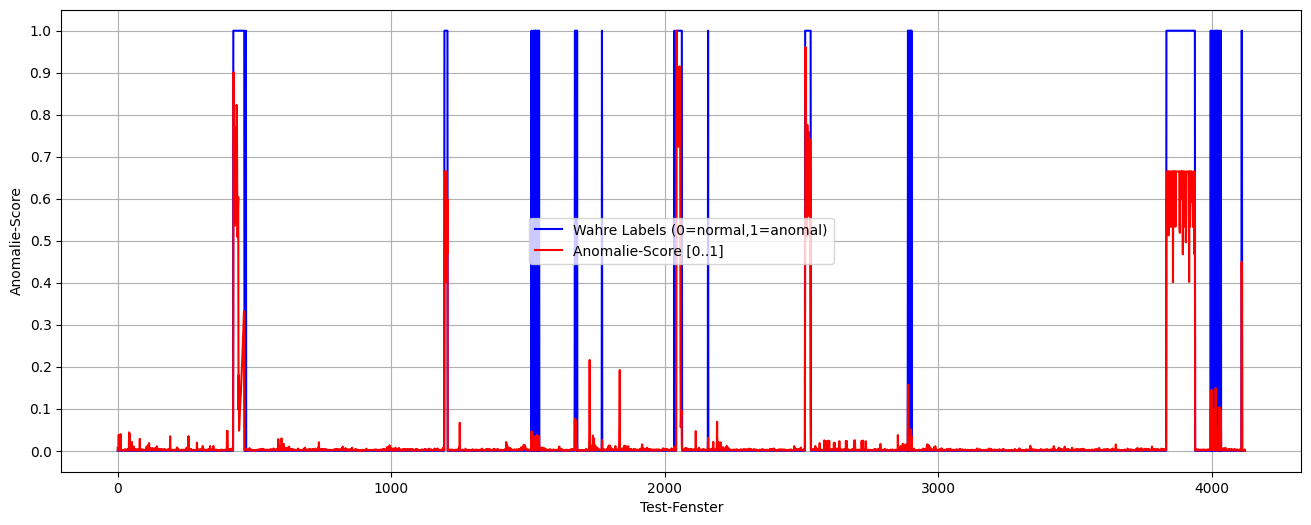

In [59]:
# bestes Modell laden
autoencoder_geladen = tf.keras.models.load_model('autoencoder.h5', compile=False)

test_fenster_vorhersage = autoencoder_geladen.predict(test_fenster_daten)

def berechne_rekon_fehler(fenster_original, fenster_pred, fenster_size, anzahl_dims):
    fehler_liste = []
    for i in range(fenster_original.shape[0]):
        diff = fenster_original[i] - fenster_pred[i]
        # Mittelwert der Norm über die Zeitachse
        re = np.mean(np.linalg.norm(diff, axis=1))
        fehler_liste.append(re)
    return np.array(fehler_liste)

rekonstruktions_fehlertest = berechne_rekon_fehler(
    test_fenster_daten,
    test_fenster_vorhersage,
    fenster_groesse,
    pca_modell.n_components_
)
rekonstruktions_fehlertest = rekonstruktions_fehlertest.reshape(-1, 1)

minmax_scaler = MinMaxScaler()
anomalie_scores_test = minmax_scaler.fit_transform(rekonstruktions_fehlertest).flatten()

# Plot
plt.figure(figsize=(16, 6))
plt.plot(test_fenster_labels, c='blue', label='Wahre Labels (0=normal,1=anomal)')
plt.plot(anomalie_scores_test, c='red', label='Anomalie-Score [0..1]')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Test-Fenster')
plt.ylabel('Anomalie-Score')
plt.grid()
plt.legend()
plt.show()

## <a id='toc1_14_'></a>[Verschiedene Metriken](#toc0_)

## <a id='toc1_15_'></a>[Kategoriale Kenngrößen](#toc0_)

## <a id='toc1_16_'></a>[Metriken für Klassifikationsmodelle](#toc0_)

### <a id='toc1_16_1_'></a>[Accuracy (Standard)](#toc0_)
Im einfachsten Fall wird die Summe der Übereinstimmungen $ \hat{Y} = Y $ durch die insgesamte Anzahl an Datensätzen dividiert. Dadurch wird der Prozentsatz der Übereinstimmungen ermittelt. Diese Metrik eignet sich bei Single-Label-Klassifikationen (pro Datensatz gibt es nur eine einzige Ausprägung von $ Y $). Die Accuracy ist in diesem Datensatz mit Vorsicht zu genießen, die Datenanalyse am Anfang hat gezeigt, dass nur 0,48% der Daten Anormalien sind, bei einer Accuracy von 0,995 wäre es also möglich, dass keine einzige Anormalie erkannt wurde, trotzdem sieht die Accuracy erstmal gut aus.

$
\text{Accuracy} = \frac{\text{Summe der Übereinstimmungen}}{\text{Gesamtanzahl der Datensätze}}
$

#### <a id='toc1_16_1_1_'></a>[Precision](#toc0_)
Diese Metrik errechnet sich gemäß:

$
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
$

---

#### <a id='toc1_16_1_2_'></a>[Recall](#toc0_)
Diese Metrik errechnet sich gemäß:

$
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$

---

#### <a id='toc1_16_1_3_'></a>[F1-Score](#toc0_)
Der F1-Score wird als harmonisches Mittel von Precision und Recall berechnet:

$
\text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$

---

#### <a id='toc1_16_1_4_'></a>[Tabelle: Übersicht der Begriffe](#toc0_)
| Tatsächlich/Vorhersage | **1** (Positiv) | **0** (Negativ) |
|-------------------------|-----------------|-----------------|
| **1** (Positiv)         | TPR (True Positive) | FNR (False Negative) |
| **0** (Negativ)         | FPR (False Positive) | TNR (True Negative) |



### <a id='toc1_16_2_'></a>[ROC und AUC-Bewertung](#toc0_)

#### <a id='toc1_16_2_1_'></a>[Visualisierung](#toc0_)
Wir plotten FPR gegen TPR und geben den AUC-Wert an.


#### <a id='toc1_16_2_2_'></a>[Wichtige Aspekte](#toc0_)
- Kurve nahe (0,1) deutet auf sehr gute Trennung hin
- Diagonale = zufällige Klassifikation


AUC-Wert: 0.9982570309688439


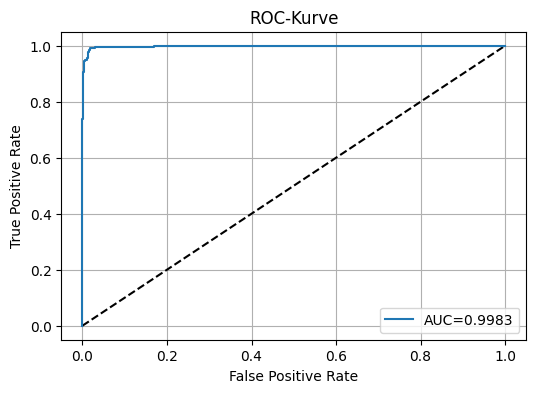

In [63]:
fpr_roc, tpr_roc, thresholds_roc = roc_curve(test_fenster_labels, anomalie_scores_test)
auc_roc = roc_auc_score(test_fenster_labels, anomalie_scores_test)
print('AUC-Wert:', auc_roc)

plt.figure(figsize=(6, 4))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.plot(fpr_roc, tpr_roc, label=f'AUC={auc_roc:.4f}')
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC-Kurve')
plt.show()

### <a id='toc1_16_3_'></a>[Precision-Recall-Kurve und Average Precision (AP)](#toc0_)

Average Precision (AP): 0.9822765199527165


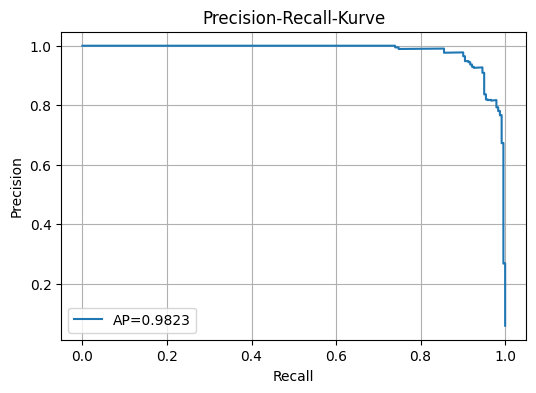

In [62]:
precisions, recalls, schwellen_pr = precision_recall_curve(test_fenster_labels, anomalie_scores_test)
ap_wert = average_precision_score(test_fenster_labels, anomalie_scores_test)
print('Average Precision (AP):', ap_wert)

plt.figure(figsize=(6, 4))
plt.plot(recalls, precisions, label=f'AP={ap_wert:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall-Kurve')
plt.grid()
plt.legend()
plt.show()

### <a id='toc1_16_4_'></a>[F1-Score-Kurve basierend auf Schwellenwerten](#toc0_)

#### <a id='toc1_16_4_1_'></a>[Schritte zur Berechnung der F1-Score-Kurve](#toc0_)
1. Durchiterieren verschiedener Schwellen.
2. Klassifikation (0/1) je nach Score.
3. F1-Score berechnen.


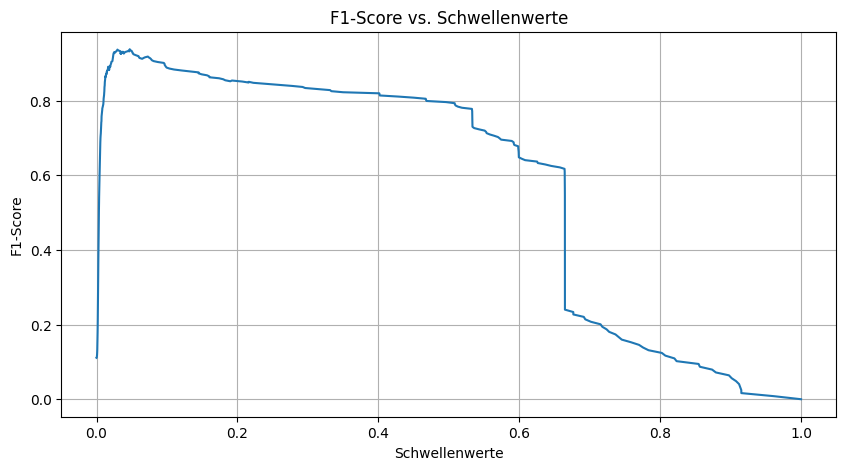

In [60]:
alle_schwellen = np.sort(anomalie_scores_test)
f1_werte = []
for schwelle in alle_schwellen:
    prädiktion = (anomalie_scores_test > schwelle).astype(np.int32)
    f1_aktuell = f1_score(test_fenster_labels, prädiktion)
    f1_werte.append(f1_aktuell)

plt.figure(figsize=(10, 5))
plt.plot(alle_schwellen, f1_werte)
plt.grid()
plt.xlabel('Schwellenwerte')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Schwellenwerte')
plt.show()

### <a id='toc1_16_5_'></a>[Schwellenwertoptimierung und Bewertung der Anomalieerkennung](#toc0_)

#### <a id='toc1_16_5_1_'></a>[Berechnung der Bewertungsmetriken](#toc0_)
- Konfusionsmatrix
- Precision, Recall, F1, Accuracy


Bester Schwellenwert auf Basis F1=0.0471, F1=0.9376


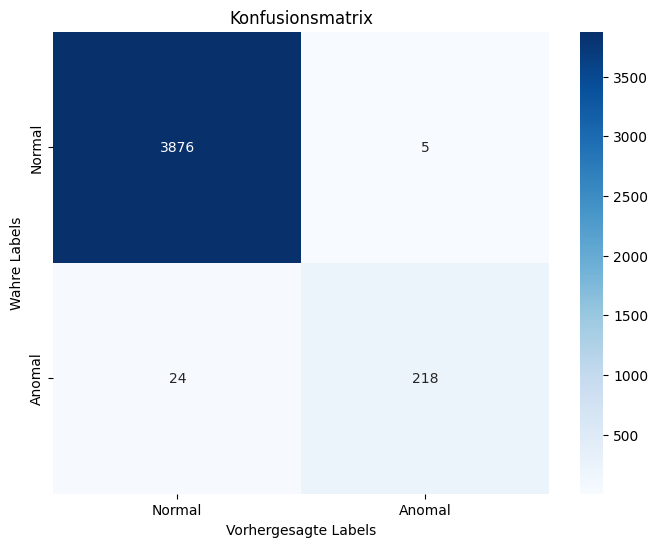

Endgültige Klassifikationsmetriken:
 Precision = 0.9776
 Recall    = 0.9008
 F1        = 0.9376
 Accuracy  = 0.9930



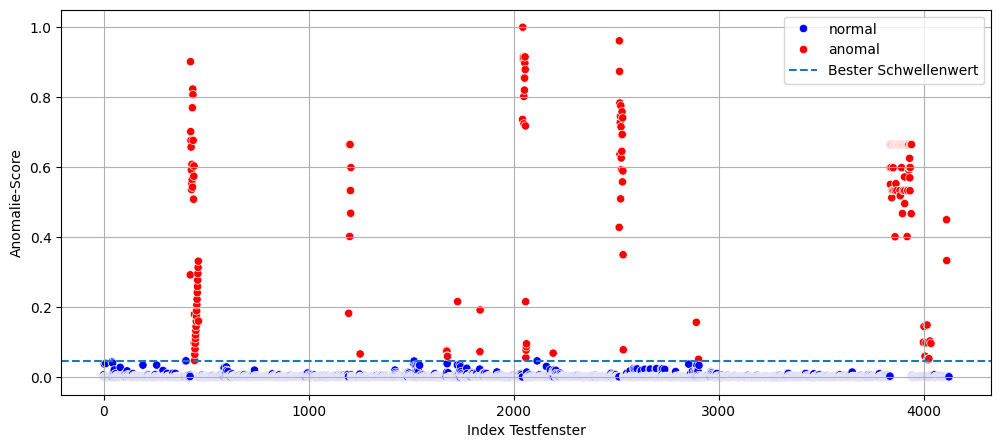

In [61]:
# Schwellenwertoptimierung
schwellen_alle = np.sort(anomalie_scores_test)
bester_f1 = 0
bester_schwellenwert = 0

for schwelle in schwellen_alle:
    pred_schwell = (anomalie_scores_test > schwelle).astype(int)
    akt_f1 = f1_score(test_fenster_labels, pred_schwell)
    if akt_f1 > bester_f1:
        bester_f1 = akt_f1
        bester_schwellenwert = schwelle

print(f'Bester Schwellenwert auf Basis F1={bester_schwellenwert:.4f}, F1={bester_f1:.4f}')

final_pred = (anomalie_scores_test > bester_schwellenwert).astype(int)
konf_matrix = confusion_matrix(test_fenster_labels, final_pred)

# Verbesserte Darstellung der Konfusionsmatrix
labels = ['Normal', 'Anomal']
plt.figure(figsize=(8, 6))
sns.heatmap(konf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Konfusionsmatrix')
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Wahre Labels')
plt.show()

precision_erg = precision_score(test_fenster_labels, final_pred)
recall_erg = recall_score(test_fenster_labels, final_pred)
f1_erg = f1_score(test_fenster_labels, final_pred)
accuracy_erg = accuracy_score(test_fenster_labels, final_pred)

print('Endgültige Klassifikationsmetriken:\n',
      f'Precision = {precision_erg:.4f}\n',
      f'Recall    = {recall_erg:.4f}\n',
      f'F1        = {f1_erg:.4f}\n',
      f'Accuracy  = {accuracy_erg:.4f}\n')

# Visualisierung
plt.figure(figsize=(12, 5))
sns.scatterplot(
    x=np.arange(0, len(anomalie_scores_test)), 
    y=anomalie_scores_test,
    hue=['normal' if x==0 else 'anomal' for x in final_pred],
    palette=['blue', 'red'], legend='full'
)
plt.axhline(y=bester_schwellenwert, linestyle='--', label='Bester Schwellenwert')
plt.xlabel('Index Testfenster')
plt.ylabel('Anomalie-Score')
plt.legend()
plt.grid()
plt.show()


## <a id='toc1_17_'></a>[Anomalieerkennung im Produktionsdatensatz](#toc0_)
Abschließend wenden wir das trainierte Modell auf Produktionsdaten an (unbekannte Daten).

#### <a id='toc1_17_1_1_'></a>[Schritte zur Datenverarbeitung](#toc0_)
- Laden
- HTTP filtern
- Cleaning/Skalierung/PCA
- Fensterbildung
- Rekonstruktionsfehler & Scores
- Klassifikation über best. Schwellenwert

#### <a id='toc1_17_1_2_'></a>[Anmerkung](#toc0_)
Dies dient als Demonstration, wie ein Modell in Produktionsumgebungen Abweichungen erkennen kann.


Form des Produktionsdatensatzes (HTTP): (41192, 42)


100%|██████████| 4119/4119 [00:00<00:00, 31999.92it/s]


129/129 [==============================] - 20s 150ms/step


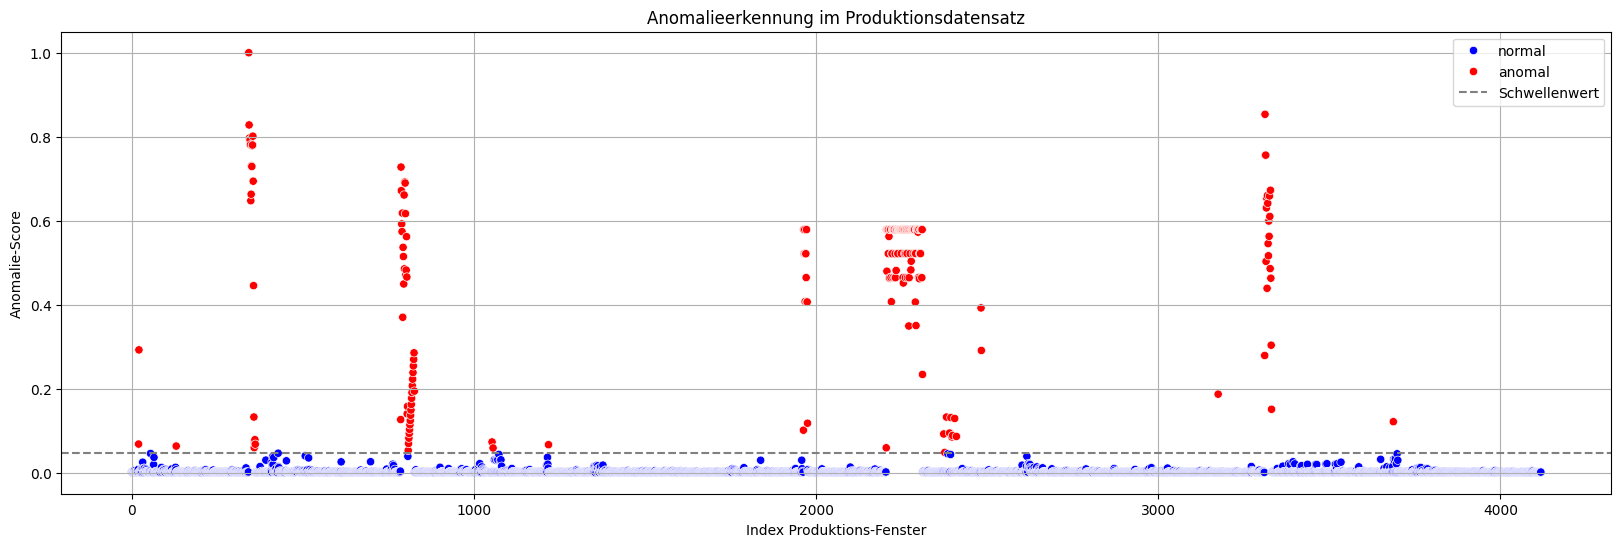

In [70]:
df_prod = pd.read_csv(PROD_DATEN_PFAD, header=None, names=bereinigte_spaltennamen)

# nur http
df_prod_http = df_prod[df_prod['service'] == 'http'].copy()
print('Form des Produktionsdatensatzes (HTTP):', df_prod_http.shape)

# Cleaning
df_prod_http.drop([
    'protocol_type', 'service', 'flag', 'land',
    'is_host_login', 'is_guest_login', 'result'
], axis=1, inplace=True)
df_prod_http.drop([
    'wrong_fragment', 'urgent', 'num_failed_logins', 'su_attempted',
    'num_file_creations', 'num_outbound_cmds'
], axis=1, inplace=True)
# aufgrund hoher Korrelationen wird die Spalte 'logged_in' entfernt (leide nur manuell)
df_prod_http =df_prod_http.drop(columns=['logged_in'])
# Skalierung
df_prod_http = pd.DataFrame(
    skalierer.transform(df_prod_http),
    columns=df_prod_http.columns
)

# PCA
df_prod_http_pca = pd.DataFrame(
    pca_modell.transform(df_prod_http),
    columns=df_train_pca.columns
)

prod_fenster = fenster_bilden(df_prod_http_pca, fenster_groesse=fenster_groesse, schritt=schrittweite)
prod_fenster_pred = autoencoder_geladen.predict(prod_fenster)

prod_fehler = berechne_rekon_fehler(
    prod_fenster,
    prod_fenster_pred,
    fenster_groesse,
    pca_modell.n_components_
)
prod_fehler = prod_fehler.reshape(-1, 1)

# Normalisierung
scaler_prod = MinMaxScaler()
prod_scores = scaler_prod.fit_transform(prod_fehler).flatten()

prod_anomal = (prod_scores > bester_schwellenwert).astype(np.int32)

plt.figure(figsize=(20,6))
sns.scatterplot(
    x=np.arange(0, len(prod_scores)),
    y=prod_scores,
    hue=['normal' if x==0 else 'anomal' for x in prod_anomal],
    palette=['blue', 'red'], legend='full'
)
plt.axhline(y=bester_schwellenwert, linestyle='--', label='Schwellenwert', color='gray')
plt.title('Anomalieerkennung im Produktionsdatensatz')
plt.xlabel('Index Produktions-Fenster')
plt.ylabel('Anomalie-Score')
plt.legend()
plt.grid()
plt.show()


### <a id='toc1_17_2_'></a>[Ausgabe der gefundenen Anormalien](#toc0_)

In [23]:
# Extraktion der Anomalie-Fenster
anomalie_df_liste = []

for i, (score, ind) in enumerate(zip(prod_scores, prod_anomal)):
    if ind == 1:
        start_idx = i * schrittweite
        end_idx = start_idx + fenster_groesse
        fenster_subset = df_prod_http.iloc[start_idx:end_idx].copy()
        fenster_subset['anomalie_score'] = score
        fenster_subset['fenster_index'] = i
        anomalie_df_liste.append(fenster_subset)

anomalien_prod = pd.concat(anomalie_df_liste, axis=0)
anomalien_prod = anomalien_prod.sort_values(by='anomalie_score', ascending=False)

print("Gefundene Anomalien (sortiert nach Score):")
print(anomalien_prod)

# Optional als CSV
anomalien_prod.to_csv("anomalien_produktiv.csv", index=False)
print("Die Tabelle der Anomalien wurde in 'anomalien_produktiv.csv' gespeichert.")

NameError: name 'prod_scores' is not defined

## <a id='toc1_18_'></a>[Ausblick](#toc0_)

Das Modell liefert noch keine perfekten Ergebnisse, weitere Anpassungen auf Basis neuerster Referenz Entwicklungen könnte sinnvoll sein.

Um den Wert der Ergebnisse zu erhöhen sollte in Zukunft das Modell um eine Klassifizierung der Angriffe erweiterte werden.

Es ist zu beachten, dass der KDD mittlerweile veraltet ist, daher könnten die Logdaten in der Bachelorthesis, welche vom BSI bereitgestellt werden, neue Chancen aber auch Probleme bergen.
Die Logs des BSI werden nicht gelabelt sein, was den bisherigen Ansatz unbrauchbar macht. Ziel könnte es sein einen Weg zu finden ohne ein manuelles Labeling die Daten nutzbar zu machen.

Das Modell sollte im besten Fall in der Lage sein nahezun in Echtzeit Daten zu bewerten.

Konsistente Datenbereinigung über Funktion wäre sinnvoll.
